In [12]:
# import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
from skimage import util 
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

In [17]:
# get the data as well as show image function
from ipynb.fs.full.z_util  import show_images,get_train,get_test,get_unlabel
from sklearn.preprocessing import OneHotEncoder
train_data,train_label = get_train()
test_data ,test_label  = get_test()
unlabeled              = get_unlabel()

In [45]:
# one hot encode the labels
np.set_printoptions(threshold=np.nan)
encoder = OneHotEncoder(sparse =True)
train_label_encoded = encoder.fit_transform(train_label[:,None]).toarray()
test__label_encoded = encoder.fit_transform(test_label [:,None]).toarray()
print(train_label[:10],'\n',train_label_encoded[:10])
print(test_label[:10],'\n', test__label_encoded[:10])

[ 2  6  2  7  4 10  8  5  6  9] 
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[7 8 6 1 4 2 2 2 5 5] 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


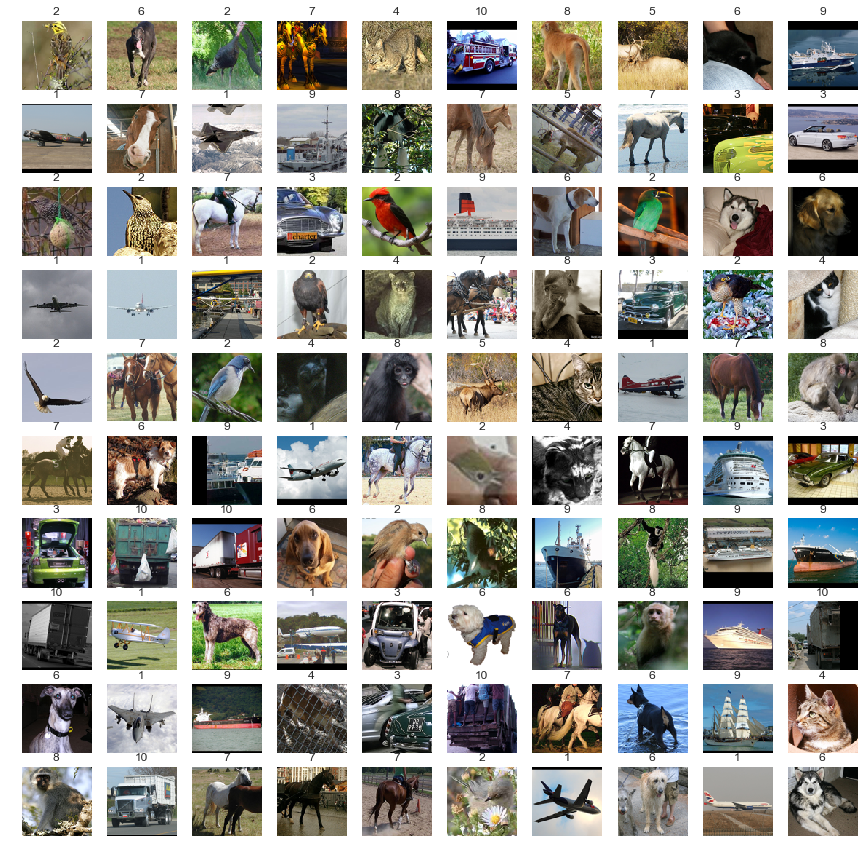

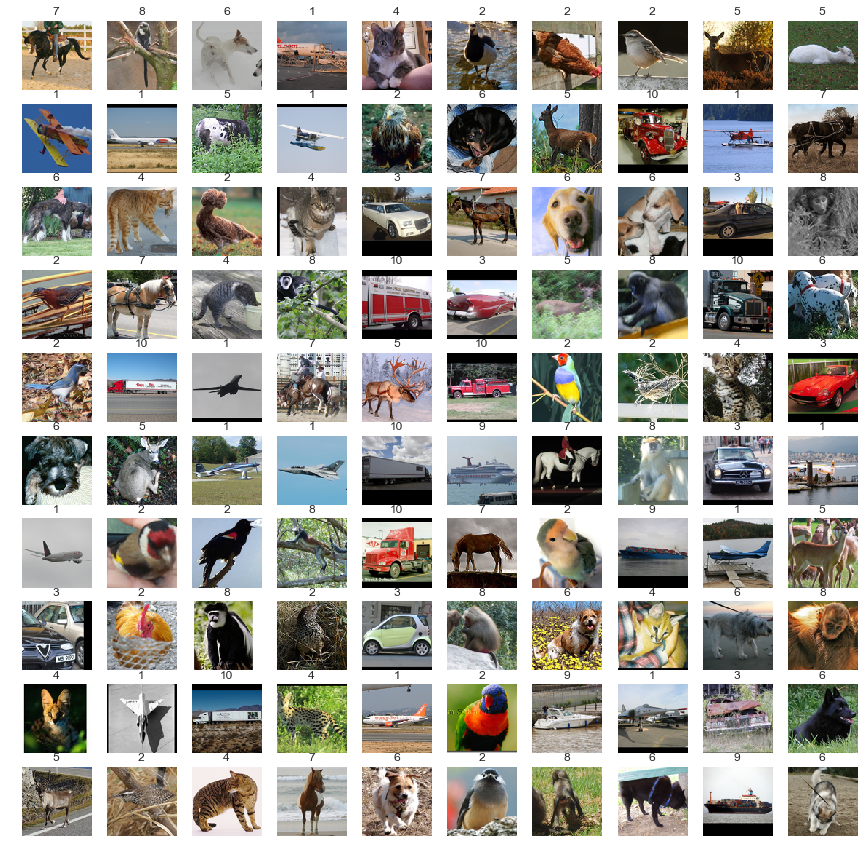

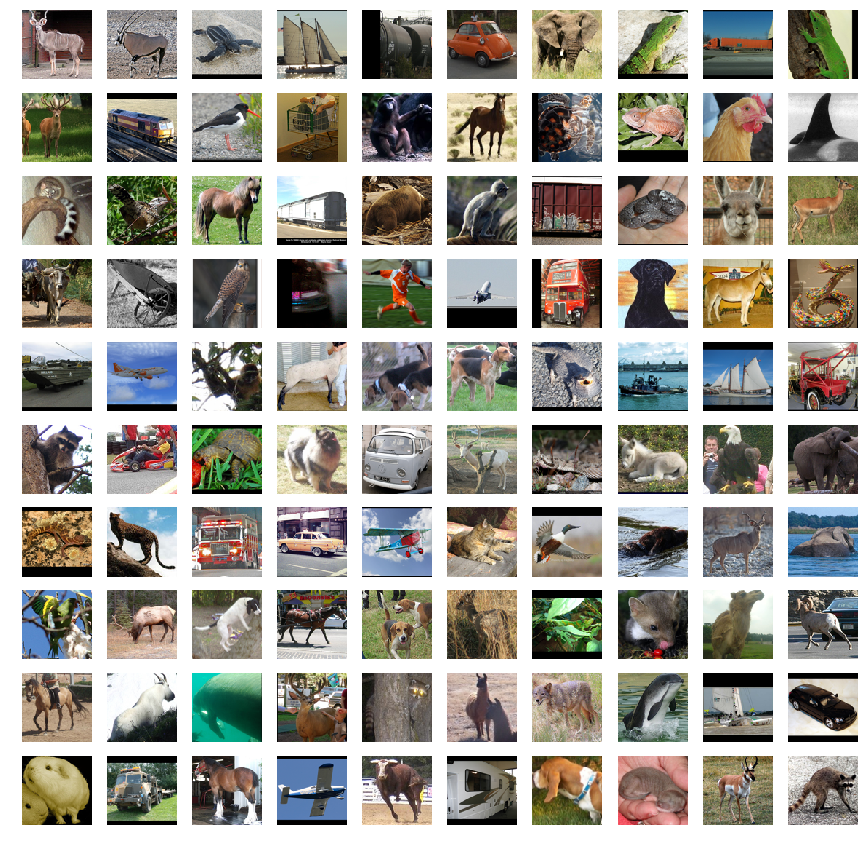

In [14]:
# show some images of train test and unlabeld
show_images(train_data,train_label)
show_images(test_data,test_label)
show_images(unlabeled,None)

In [55]:
# import layers

# Set of activation layers 
def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float64)

# Set of activation layers 

# prob layer
def tf_softmax(x): return tf.nn.softmax(x)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w          = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float64))
        self.b          = tf.Variable(tf.zeros(out,dtype=tf.float64))
        self.m,self.v   = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.mb,self.vb = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg  = which_reg
        
    def getw(self): return [self.w,self.b]

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) + self.b
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),
        filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        if self.which_reg == 0:   grad = grad
        if self.which_reg == 0.5: grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
        if self.which_reg == 1:   grad = grad + lamda * tf.sign(self.w)
        if self.which_reg == 1.5: grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
        if self.which_reg == 2:   grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
        if self.which_reg == 2.5: grad = grad + lamda * 2.0 * self.w
        if self.which_reg == 3:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
        if self.which_reg == 4:   grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [52]:
# hyper parameters and layers
num_epoch = 100; learning_rate = 0.0008; batch_size = 10
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN(3,3,32)
l2 = CNN(4,32,64)
l3 = CNN(3,64,128)
l4 = CNN(3,128,256)
l5 = CNN(4,256,10)

In [57]:
# create graph
x = tf.placeholder(shape=[batch_size,96,96,3],dtype=tf.float64)
y = tf.placeholder(shape=[batch_size,10],dtype=tf.float64)
temperature = tf.placeholder(shape=(),dtype=tf.float64)

layer1      = l1.feedforward(x)
layer1_pool = tf.nn.avg_pool(layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer2      = l2.feedforward(layer1_pool)
layer2_pool = tf.nn.avg_pool(layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer3      = l3.feedforward(layer2_pool)
layer3_pool = tf.nn.avg_pool(layer3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer4      = l4.feedforward(layer3_pool)
layer4_pool = tf.nn.avg_pool(layer4,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer5      = l5.feedforward(layer4_pool)

final_squeeze_temp = tf.squeeze(layer5)/temperature
cost               = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_squeeze_temp,labels=y)
final_prediction   = tf_softmax(final_squeeze_temp) 
print(final_prediction)

Tensor("Softmax_1:0", shape=(10, 10), dtype=float64)


In [54]:
# start the session
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())
# sess_results = sess.run(final_prediction,feed_dict={x:train_datas[:batch_size,:,:,:]})

# Reference
1. file, i. (2018). import a function from another .ipynb file. Stack Overflow. Retrieved 11 November 2018, from https://stackoverflow.com/questions/44116194/import-a-function-from-another-ipynb-file
2. array?, H. (2018). How to print the full NumPy array?. Stack Overflow. Retrieved 11 November 2018, from https://stackoverflow.com/questions/1987694/how-to-print-the-full-numpy-array
3. Label Encoder vs. One Hot Encoder in Machine Learning. (2018). Medium. Retrieved 11 November 2018, from https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
4. API Reference — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 11 November 2018, from https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
5. 